# Insurance Losses - dataset analysis
---
This dataset represents the losses by policy_number of an insurance car company. An exploratory analysis will be taken in order to understand what kind of insights is possible to harvest from this dataset.


In [0]:
# importing the core lib
import pandas as pd
import numpy as np
from scipy import stats
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
# downloading the csv file from the drive
%%sh
wget --quiet --output-document insurance_losses.csv 'https://drive.google.com/uc?authuser=0&id=1X-jvKn6mwxmyyqFidvC2eU3GjAQyFKvx&export=download'

In [0]:
# turning the csv into a dataframe and renaming policy_number to be easier to use
df = pd.read_csv('insurance_losses.csv', )
df = df.rename(columns={
    'Policy Number': 'policy_number'
})

In [18]:
# showing the head of the dataframe
df.head()

,Age,Years of Driving Experience,Number of Vehicles,Gender,Married,Vehicle Age,Fuel Type,Losses
Policy Number,,,,,,,,
150023,24,5,1,M,Married,11,P,203
152720,31,10,1,F,Single,6,P,402
174207,56,37,1,M,Married,0,D,553
139895,52,31,1,F,Married,15,P,292
174407,20,3,1,M,Single,15,P,247


In [5]:
# describing the dataframe
df.describe()

,policy_number,Age,Years of Driving Experience,Number of Vehicles,Vehicle Age,Losses
count,15290.000000,15290.000000,15290.000000,15290.000000,15290.000000,15290.000000
mean,149910.276651,42.328254,23.732897,2.495880,8.655723,389.858012
std,28948.806631,18.280511,17.850707,0.953776,4.344536,253.729469
min,100002.000000,16.000000,0.000000,1.000000,0.000000,13.000000
25%,124842.000000,24.000000,6.000000,2.000000,6.000000,226.000000
50%,149872.000000,42.000000,23.000000,2.000000,9.000000,355.000000
75%,175011.000000,61.000000,42.000000,3.000000,12.000000,489.000000
max,200000.000000,70.000000,53.000000,4.000000,15.000000,3500.000000


In [6]:
#@title Histogram of Losses
df.hist(variable_name, bins=30)

NameError: ignored

In [0]:
df['Losses'].groupby(df['Married']).describe().append(df['Losses'].groupby(df['Gender']).describe())

In [0]:
#@title Boxplot with Losses by Gender and by Married
fig, ax =plt.subplots(1,2)
sns.boxplot(df['Gender'],df['Losses'], ax=ax[0])
sns.boxplot(df['Married'], df['Losses'] ,ax=ax[1])
fig.show()

In [0]:
df.groupby(['Losses']).size().plot()
plt.show()

In [0]:
# 0 = P and 1 = D

losses_by_fuel = df[['Fuel Type', 'Losses']].groupby('Fuel Type').sum()
losses_by_fuel['size'] = df.groupby('Fuel Type').size()
losses_by_fuel


,policy_number,Age,Years of Driving Experience,Number of Vehicles,Gender,Married,Vehicle Age,Fuel Type,Losses
policy_number,1,0.00066,0.0013,0.013,-0.0092,0.0051,-0.0013,0.0024,0.0046
Age,0.00066,1,1,0.0084,0.0054,-0.0043,-0.24,-0.33,-0.44
Years of Driving Experience,0.0013,1,1,0.0085,0.0074,-0.005,-0.24,-0.33,-0.44
Number of Vehicles,0.013,0.0084,0.0085,1,-0.0012,-0.0095,0.0059,-0.0034,-0.012
Gender,-0.0092,0.0054,0.0074,-0.0012,1,-0.008,-0.0035,0.17,0.18
Married,0.0051,-0.0043,-0.005,-0.0095,-0.008,1,-0.0083,-0.22,-0.27
Vehicle Age,-0.0013,-0.24,-0.24,0.0059,-0.0035,-0.0083,1,-0.29,-0.27
Fuel Type,0.0024,-0.33,-0.33,-0.0034,0.17,-0.22,-0.29,1,0.72
Losses,0.0046,-0.44,-0.44,-0.012,0.18,-0.27,-0.27,0.72,1


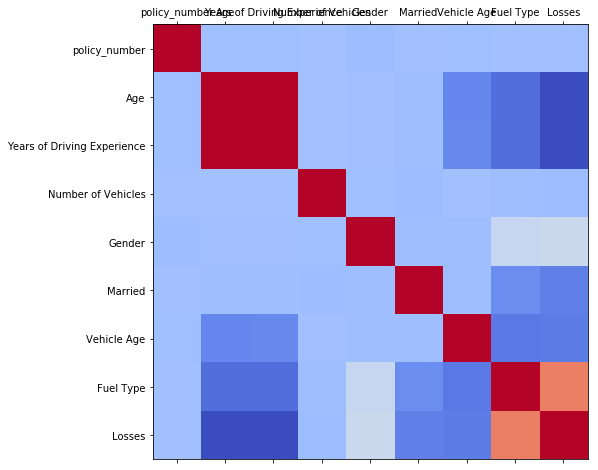

In [37]:
# Replacing non numeric data to 0 and 1 to find correlation between them
df = df.replace('Married', 1).replace('Single', 0).replace('F', 0).replace('M', 1).replace('P', 0).replace('D', 1)
corr = df.corr()
            
fig, ax = plt.subplots(figsize=(8, 8))
ax.matshow(corr, cmap='coolwarm')
plt.xticks(range(len(corr.columns)), corr.columns)
plt.yticks(range(len(corr.columns)), corr.columns)
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

On the above cell, we observed a good correlation between Losses and Age/Years of Driving Experience. Besides that, we can see a strong correlation with Fuel Type, but we need to dig deeper to understand if the relationship is about the severity.

In [0]:
# plt.scatter(df['Years of Driving Experience'], df['Losses'])
# plt.scatter(df['Age'], df['Losses'])
plt.scatter(df['Fuel Type'], df['Losses'])


# Subset Analysis
---
While analyzing the dataset, was realized that exists duplicate policy numbers, therefore needing a more in-depth analysis of a subgroup of clients that had losses with the insurance more than 1 time.


In [0]:
# We have 2244 policy_numbers duplicated in the dataset
df.duplicated(['policy_number'], keep=False).to_frame('duplicated').groupby('duplicated').size()

In [0]:
# getting the subset of only the duplicated policy_numbers
crashed_df = df[df.duplicated(subset=['policy_number'], keep=False)]
unique_pn_array = crashed_df.policy_number.unique()
print(crashed_df.count())
crashed_df.head()

In [0]:
# Understand the size of crashes by policy_numbers in the whole dataframe.
df.groupby('policy_number').size().to_frame('size').groupby('size').size().to_frame('Policy Number Amount')

In [0]:
corr = crashed_df.corr()
            
fig, ax = plt.subplots(figsize=(6, 6))
ax.matshow(corr, cmap='coolwarm')
plt.xticks(range(len(corr.columns)), corr.columns)
plt.yticks(range(len(corr.columns)), corr.columns)
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

In [0]:
fig = plt.figure()
a = crashed_df.boxplot(column=['Losses'], by='Vehicle Age')
b = crashed_df.boxplot(column=['Losses'], by='Years of Driving Experience')
c = crashed_df.boxplot(column=['Losses'], by='Gender')
d = crashed_df.boxplot(column=['Losses'], by='Fuel Type')

a.plot()
b.plot()
c.plot()
d.plot()

In [0]:
fig, ax = plt.subplots(figsize=(8, 6))
a = crashed_df[['Age', 'Losses']].groupby('Age').sum()
b = crashed_df.groupby('Age').size().plot()
plt.grid()
a.plot()
plt.grid()
b.plot()



In [0]:
fig, ax = plt.subplots(figsize=(8, 6))
a = df[['Age', 'Losses']].groupby('Age').sum()
b = df.groupby('Age').size().plot()
plt.grid()
a.plot()
plt.grid()
b.plot()

In [39]:
X = pd.DataFrame(df['Losses'])
y = pd.DataFrame(df['Age'])

model = LinearRegression()
scores = []
kfold = KFold(n_splits=2, shuffle=True, random_state=42)

for i, (train, test) in enumerate(kfold.split(X, y)):
    model.fit(X.iloc[train,:], y.iloc[train,:])
    score = model.score(X.iloc[test,:], y.iloc[test,:])
    scores.append(score)

print(scores)

[0.18789331176333868, 0.20253375868833745]
